In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# zip_path = "/content/drive/MyDrive/project.zip"


In [1]:
# path = "/content/drive/MyDrive/project"
BASE_PATH = ""

In [ ]:
# !unzip -q $zip_path -d $path

>

# 1 Import libraries

In [2]:
%pip install -U imbalanced-learn

import os
import shutil
import pathlib
import PIL
import cv2
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import random
import itertools
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from IPython.display import Image
# Plot and display architecture for InceptionV3 model
from tensorflow.keras.utils import plot_model
from IPython.display import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import ResNet50, DenseNet169, EfficientNetB3
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow .keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from PIL import Image, UnidentifiedImageError

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)


print("All done")

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


All done


## Split data into train, valid, test

In [3]:
#train, valid  and test dataframes
train = pd.read_csv(f"Dataset\\train.csv")
valid = pd.read_csv(f"Dataset\\valid.csv")
test = pd.read_csv(f"Dataset\\test.csv")

train["Paths"] = train["Paths"].apply(lambda x: f"{BASE_PATH}project/{x}".replace("\\", "/"))
test["Paths"] = test["Paths"].apply(lambda x: f"{BASE_PATH}project/{x}".replace("\\", "/"))
valid["Paths"] = valid["Paths"].apply(lambda x: f"{BASE_PATH}project/{x}".replace("\\", "/"))
train.Labels.value_counts()

Labels
normal             6373
diabetes           6326
cataract           6242
others             6128
glaucoma           6030
myopia             5967
ageDegeneration    5755
hypertension       5487
Name: count, dtype: int64

## C- Data Augmentation

In [4]:
batch_size = 20   # As smaller, As more data generated ....In views of data size
img_size = (224, 224) # standard value (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)


#Create generators

tr_G = ImageDataGenerator(
    zca_whitening=True,
    rotation_range=30.,
    fill_mode='nearest',
    )

V_G = ImageDataGenerator()

t_G = ImageDataGenerator()

#Generate Appropriate Data for fitting into model

Train = tr_G.flow_from_dataframe(train, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)
Valid = V_G.flow_from_dataframe(valid, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)
Test = t_G.flow_from_dataframe(test, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = False, batch_size = batch_size)

Found 0 validated image filenames belonging to 0 classes.
Found 0 validated image filenames belonging to 0 classes.
Found 0 validated image filenames belonging to 0 classes.


## D- Represent a sample

IndexError: index 0 is out of bounds for axis 0 with size 0

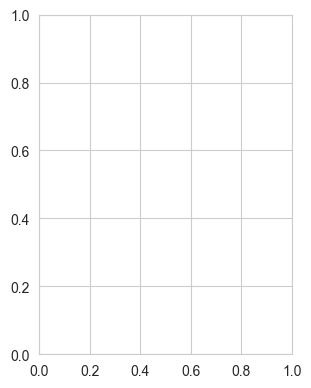

In [5]:
# Define labels and their indices as a dict
L_index = Train.class_indices
L_index

# Store Labels in a list
Keys = list(L_index.keys())
Keys

#Get a sample batch
imgs, labels = next(Train)

# Visualization
plt.figure(figsize= (15, 15))

for i in range(8):
    plt.subplot(3, 4, i +1)
    im = imgs[i]/255
    plt.imshow(im)

    #Labelling
    index = np.argmax(labels[i])
    label = Keys[index]
    plt.title(label, color = 'purple')
    plt.axis('off')

plt.tight_layout()
plt.show()

# 4 Modelling

In [7]:
# Define number of classes
num_classes = len(list(Train.class_indices.keys()))
img_shape = (img_size[0], img_size[1], 3)
EPOCHS = 15
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 6. DenseNet169

In [8]:
from tensorflow.keras.applications import DenseNet169

# Define base model
base_model = DenseNet169(include_top=False, weights='imagenet', input_shape=(img_size[0], img_size[1], 3))

# Add custom head
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create model
DenseNet169_model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
DenseNet169_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])



In [9]:
DenseNet169_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, 230, 230, 3)          0         ['input_2[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_2[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']      

## Visualise the model

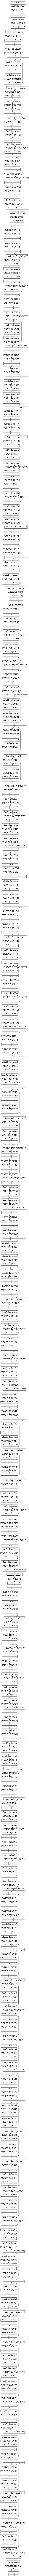

In [10]:
# Plot and display architecture for DenseNet169 model

from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(DenseNet169_model, to_file='DenseNet169_model.png', show_shapes=True, show_layer_names=True)
Image(filename='DenseNet169_model.png')

## Training the model

In [ ]:
np.random.seed(42)
# Train the model
history_DenseNet169 = DenseNet169_model.fit(
    Train,
    steps_per_epoch=Train.samples // batch_size,
    epochs=EPOCHS,
    validation_data=Valid,
    validation_steps=Valid.samples // batch_size,
    verbose=1
)

# Evaluate the model on the test set
test_loss_densenet169, test_accuracy_densenet169 = DenseNet169_model.evaluate(Test)

Epoch 1/15
2415/2415 [==============================] - 24757s 10s/step - loss: 1.3015 - accuracy: 0.5053 - val_loss: 1.2472 - val_accuracy: 0.5505
Epoch 2/15
2415/2415 [==============================] - 597s 247ms/step - loss: 1.0540 - accuracy: 0.5951 - val_loss: 1.2806 - val_accuracy: 0.5311
Epoch 3/15
2415/2415 [==============================] - 593s 245ms/step - loss: 0.9263 - accuracy: 0.6431 - val_loss: 1.1648 - val_accuracy: 0.5771
Epoch 4/15
2415/2415 [==============================] - 592s 245ms/step - loss: 0.8077 - accuracy: 0.6896 - val_loss: 0.8696 - val_accuracy: 0.6784
Epoch 5/15
2415/2415 [==============================] - 592s 245ms/step - loss: 0.6946 - accuracy: 0.7308 - val_loss: 0.7684 - val_accuracy: 0.7038
Epoch 6/15
2415/2415 [==============================] - 608s 252ms/step - loss: 0.5910 - accuracy: 0.7685 - val_loss: 0.7496 - val_accuracy: 0.7229
Epoch 7/15
2415/2415 [==============================] - 601s 249ms/step - loss: 0.5038 - accuracy: 0.7993 - val_

In [ ]:
tr_acc_DenseNet169 = history_DenseNet169.history['accuracy']
tr_loss_DenseNet169 = history_DenseNet169.history['loss']
v_acc_DenseNet169 = history_DenseNet169.history['val_accuracy']
v_loss_DenseNet169 = history_DenseNet169.history['val_loss']
index_acc_DenseNet169 = np.argmax(v_acc_DenseNet169)
high_Vacc_DenseNet169 = v_acc_DenseNet169[index_acc_DenseNet169]
index_loss_DenseNet169 = np.argmin(v_loss_DenseNet169)
low_Vloss_DenseNet169 = v_loss_DenseNet169[index_loss_DenseNet169]
Epochs_DenseNet169 = list(range(1, len(tr_acc_DenseNet169) + 1))
best_acc_DenseNet169 = f'Best epoch ={str(index_acc_DenseNet169 + 1)}'
best_loss_DenseNet169 = f'Best epoch ={str(index_loss_DenseNet169 + 1)}'

In [ ]:
# save the model
DenseNet169_model.save(f"{BASE_PATH}DenseNet169_model.h5")
# save the history of the model
np.save(f"{BASE_PATH}DenseNet169_model_history.npy", history_DenseNet169.history)

import pickle

with open(f"{BASE_PATH}history_DenseNet169.pickle", 'wb') as handle:
    pickle.dump(history_DenseNet169.history, handle, protocol=pickle.HIGHEST_PROTOCOL)